# 단어사전 만들기

## 1. 데이터 다운로드 및 분석

데이터셋: 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터
- 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분으로, 전체 병렬 말뭉치는 후에 번역기를 만들며 사용할 예정
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora)

In [ ]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [ ]:
# 코랩에서 데이터 다운로드 및 압축 해제
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz

--2025-06-13 02:44:21--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2025-06-13 02:44:22--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [ ]:
# 파일 로딩
path_to_file = '/content/korean-english-park.train.ko'

with open(path_to_file, "r", encoding='utf-8') as f:
    raw = f.read().splitlines()

# 데이터 확인
print("Data Size:", len(raw))
print("Example:")
for sen in raw[0:100][::20]:
    print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


<br>

문장은 위에서 확인한 것처럼 94123개가 포함되어 있다.

각 문장이 어느 정도의 길이를 가지는지 확인해 보자. 이 과정을 거치면 지나치게 긴 데이터를 삭제하거나 (연산량을 감소시켜 학습 속도가 빨라짐) 지나치게 짧은 데이터를 검증 (물론 단어 ↔ 단어 라면 번역을 학습할 수 있음) 할 수 있다. 즉, 데이터를 얼마나 사용할지 타협점을 정의할 수 있다.

문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프 시각화
- raw 변수는 앞서 다운로드받은 데이터가 담긴 변수

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


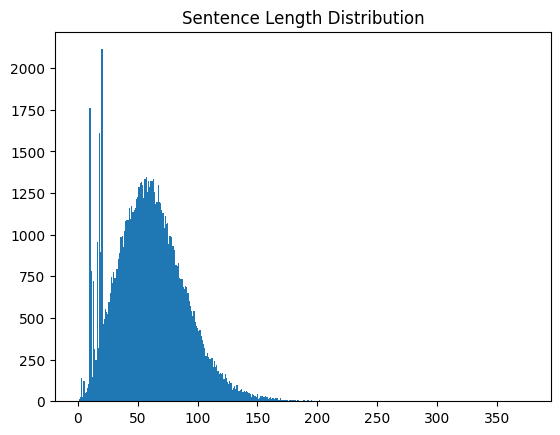

In [ ]:
# 문장 길이 통계 분석
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

# 시각화
sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

결과 해석  

1) 길이 1 짜리 문장은 어떻게 생겨지?  
2) 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가?  
3) 어디서부터 어디까지 잘라서 쓰지?  






In [ ]:
# 길이가 1인 문장 확인하기
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


노이즈인 데이터로 확인된다.

길이별로 확인하기위해 함수를 미리 정의해두었는데, 이를 이용해 확인이 필요해 보이는 문장을 모두 확인해 보자.

In [ ]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


위에서 찾은 outlier index 중 하나인, 길이가 11인 문장들은 어떤 것들이 있는지 확인해 보자.

In [ ]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

중복에 대한 처리가 되어있지 않은 것을 확인할 수 있다.

중복 제거는 Python의 기본 자료형 set을 활용한다.
- set은 집합을 정의하는 자료형인데, 중복을 허용하지 않아 변환 과정에서 자동으로 중복된 요소를 제거
- 대신 list의 순서가 뒤죽박죽될 수 있으니, 만약 번역 데이터처럼 쌍을 이뤄야 하는 경우라면 주의



중복을 제거한 후, 앞에서 분포를 확인한 소스를 다시 실행한다.

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


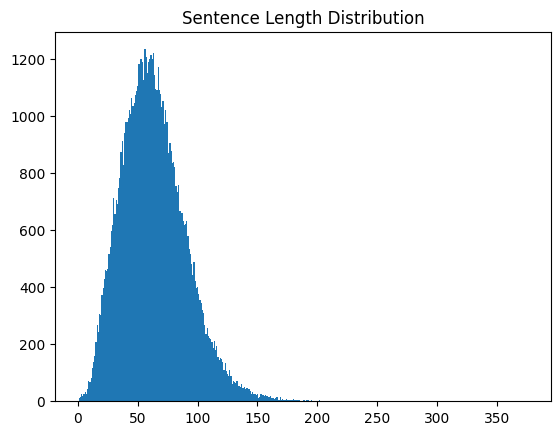

In [ ]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해 중복 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

안정적인 데이터 분포를 확인할 수 있다. 데이터의 개수도 17000개 가량 줄어 77591개가 되었다.

'모든 데이터를 다 사용할 것이냐'
- 후에 미니 배치를 만들 것을 생각하면 모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적
- 미니 배치 특성상 각 데이터의 크기가 모두 동일해야 하기 때문에 가장 긴 데이터를 기준으로 Padding 처리를 해야 함
- 위의 데이터에서 만약 길이가 100인 문장까지만 사용한다면 데이터는 [ (77591 - 길이 100 초과 문장 수) x 100 ] 의 형태를 갖겠지만 모두 사용할 경우 [ 77591 x 377 ] 로 전자보다 최소 3.7배 큰 메모리를 차지함
- 학습 시간도 그만큼 더 오래 걸림
- 길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 지양

여기서는 길이 150 이상의 데이터를 제거하고 사용하겠다.

그리고 앞서 확인한 것처럼 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있다. 따라서 길이가 10 미만인 데이터도 제거한다.

최종 데이터 분포도 함께 확인해 보자.






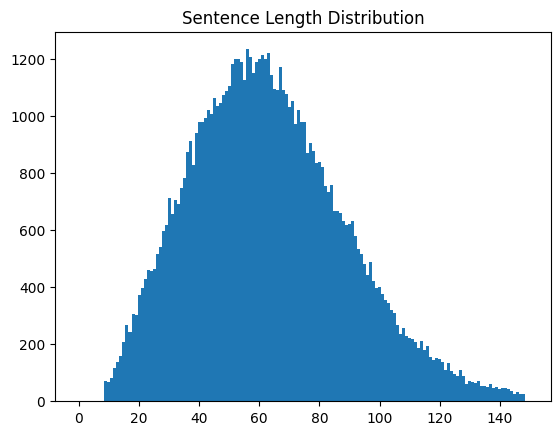

In [ ]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도 다시 그리기
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

<br>
<br>

## 2. 공백 기반 토큰화

이전 스텝에서 얻은 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 리스트 split_corpus에 저장한 후, tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻는다. 그리고 단어 사전의 크기를 확인한다.

In [ ]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [ ]:
# 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [ ]:
# 공백 기반 토큰화를 진행한 후, 단어 사전의 길이 확인
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [ ]:
# 생성된 단어 사전 확인
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


동사로 이루어진 단어를 살피면 공백 기반 토큰화의 문제점을 확인할 수 있다.

1번 단어인 `밝혔다.` 는 `밝히다` , `밝다` 등과 유사한 의미를 지니고 있음에도 전혀 다른 단어로 분류될 것이다. 이 때문에 공백 기반 토큰화는 불필요하게 큰 단어 사전을 가지게 되며 이는 연산량 증가로 이어진다.

만일 밝 + 혔다 라고 토큰화했다면 어땠을까? 밝 + 히다, 밝 + 다 같은 구절이 등장했을 때, 공통된 어절인 밝 은 하나로 묶여 학습 중에 의미를 파악하기가 수월해진다. 동시에 단어 사전도 효율적으로 축소될 것이다.

이를 위해 형태소 분석기가 존재한다.

<br>
<br>

## 3. 형태소 기반 토큰화

** MeCab 설치에서 문제가 생겨 LMS에서 실습한 출력 로그를 추가하였습니다.

한국어 형태소 분석기는 대표적으로 Khaiii와 KoNLPy가 사용된다. 이번에는 KoNLPy, 그중에서도 가장 성능이 준수한 MeCab클래스를 활용한다.

MeCab 기반으로 생성된 단어 사전과 Tensor 데이터를 얻어 보자.

In [ ]:
# !pip install cython
# !pip install 'nemo_toolkit[all]'
# !curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 13.8 MB/s eta 0:00:00


In [ ]:
# GitHub에서 설치 스크립트 클론
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 3.55 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
# 설치 스크립트 실행
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-06-13 04:41:13--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.142.25, 104.192.142.26, 104.192.142.24, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31039 (30K) [text/html]
Saving to: ‘mecab-0.996-ko-0.9.2.tar.gz’

mecab-0.996-ko-0.9. 100%[===================>]  30.31K  --.-KB/s    in 0.06s   

2025-06-13 04:41:14 (510 KB/s) - ‘mecab-0.996-ko-0.9.2.tar.gz’ saved [31039/31039]

Done
Unpacking mecab-0.996-ko-0.9.2.tar.gz.......
Done
Change Directory to mecab-0.996-ko-0.9.2.......
Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh: line 23: cd: mecab-0.996-ko-0.9.2/: No such file or directory
installing mecab-0.996-ko-0.9.2.tar.gz........
configure
m

In [ ]:
# # konlpy를 거치지 않고 mecab-python3 모듈만 쓰는 방식
# # : 이 방법은 konlpy와 완전히 호환되지 않으며 토크나이저의 API가 다름
# !pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
# 테스트
from konlpy.tag import Mecab
# from mecab import MeCab

mecab = Mecab()
print(mecab.morphs("자연어처리는 참 흥미롭습니다."))

In [ ]:
# MeCab 단어 사전을 만들기
# - mecab.morphs()를 사용하여 형태소 분석
from konlpy.tag import Mecab

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [ ]:
# 형태소 기반 토큰화를 진행한 후, 단어 사전의 길이 확인
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

```
MeCab Vocab Size: 52279
```

앞서 공백 기반 단어 사전에 비해 단어 수가 현저히 줄어든 것을 확인할 수 있다. 이는 곧 연산량의 감소로 이어져 더 빠른 학습을 가능케 하고, 심지어 모델이 튜닝해야 하는 매개변수(Parameter) 수가 줄어들어 학습도 더 잘 된다. 적어도 한국어를 처리할 때는 공백 기반 토큰화를 절대 지양해야 한다.

자주 사용되는 SentencePiece같은 Subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례들이 종종 있는데, ETRI에서 발표한 한국어 BERT 모델인 KorBERT가 대표적인 사례 중 하나이다.

[공공 인공지능 오픈 API·DATA 서비스 포털](https://aiopen.etri.re.kr/bertModel)에서 모델의 자세한 구조뿐 아니라 KorBERT 모델을 5가지 자연어 처리 태스크를 기준으로 평가했던 흥미로운 결과도 살펴볼 수 있다.

